This notebook is just going to be some basic plotting & analysis of the results of the bagging + KANs experiments I did. 

In [10]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
bag_of_kans_10_bootstraps_result_path = "../../bag_of_kans_results_export/final_loss_data_10_bootstraps.csv"

df_10_bootstraps = pl.read_csv(bag_of_kans_10_bootstraps_result_path)

df_10_bootstraps.head()

R2,MSE,MAE,MAPE,RMSE,train_or_test,trial_num,model_type
f64,f64,f64,f64,f64,str,i64,str
0.931437,0.25972,0.386977,1.7441e12,0.509627,"""train""",0,"""single_kan"""
0.904339,0.586293,0.575167,0.356381,0.765698,"""test""",0,"""single_kan"""
0.920883,0.299699,0.411231,1.4291e12,0.547447,"""train""",0,"""bag_of_kans"""
0.901272,0.605089,0.579795,0.375008,0.777875,"""test""",0,"""bag_of_kans"""
0.926524,0.309339,0.424365,2.7047e12,0.556183,"""train""",1,"""single_kan"""


In [4]:
bag_of_kans_25_bootstraps_result_path = "../../bag_of_kans_results_export/final_loss_data_25_bootstraps.csv"

df_25_bootstraps = pl.read_csv(bag_of_kans_25_bootstraps_result_path)

df_25_bootstraps.head()

R2,MSE,MAE,MAPE,RMSE,train_or_test,trial_num,model_type
f64,f64,f64,f64,f64,str,i64,str
0.931437,0.25972,0.386977,1.7441e12,0.509627,"""train""",0,"""single_kan"""
0.904339,0.586293,0.575167,0.356381,0.765698,"""test""",0,"""single_kan"""
0.925575,0.281925,0.403995,1.9362e12,0.530966,"""train""",0,"""bag_of_kans"""
0.902607,0.596905,0.58244,0.367755,0.772597,"""test""",0,"""bag_of_kans"""
0.926524,0.309339,0.424365,2.7047e12,0.556183,"""train""",1,"""single_kan"""


In [29]:
# checking that the results for the single kan are the same for both. They started with the same random seeds so they 
# should be identical.
single_kan_results_from_10_bootstraps = df_10_bootstraps.filter(pl.col('model_type') == 'single_kan')
single_kan_results_from_25_bootstraps = df_25_bootstraps.filter(pl.col('model_type') == 'single_kan')

for col_10_bs, col_25_bs in zip(single_kan_results_from_10_bootstraps.iter_columns(), 
                                  single_kan_results_from_25_bootstraps.iter_columns()):
    if col_10_bs.dtype.is_numeric() and col_25_bs.dtype.is_numeric():
        assert np.allclose(col_10_bs.to_numpy(), col_25_bs.to_numpy(), rtol=1e-5)
    
    else:
        assert np.all(col_10_bs.to_numpy() == col_25_bs.to_numpy())

In [52]:
# join the results from the 25 bootstraps with the results from the 10 bootstraps to create final dataframe
bag_of_kan_results_from_25_bootstraps = df_25_bootstraps.filter(pl.col('model_type') == 'bag_of_kans')

bag_of_kan_results_from_25_bootstraps = bag_of_kan_results_from_25_bootstraps.with_columns(num_bootstraps=pl.lit(25))

df_10_bootstraps = df_10_bootstraps.with_columns(num_bootstraps= pl.col('model_type').map_elements(lambda x: 10 if x == 'bag_of_kans' else 0, return_dtype=pl.Int32))

df_all = df_10_bootstraps.vstack(bag_of_kan_results_from_25_bootstraps)

df_all.head()

R2,MSE,MAE,MAPE,RMSE,train_or_test,trial_num,model_type,num_bootstraps
f64,f64,f64,f64,f64,str,i64,str,i32
0.931437,0.25972,0.386977,1.7441e12,0.509627,"""train""",0,"""single_kan""",0
0.904339,0.586293,0.575167,0.356381,0.765698,"""test""",0,"""single_kan""",0
0.920883,0.299699,0.411231,1.4291e12,0.547447,"""train""",0,"""bag_of_kans""",10
0.901272,0.605089,0.579795,0.375008,0.777875,"""test""",0,"""bag_of_kans""",10
0.926524,0.309339,0.424365,2.7047e12,0.556183,"""train""",1,"""single_kan""",0


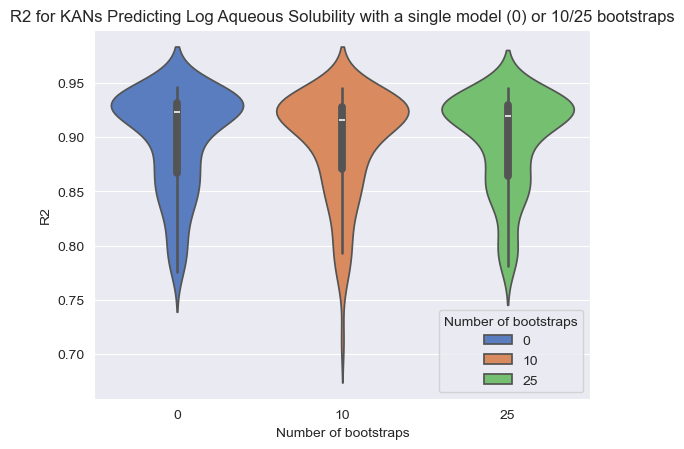

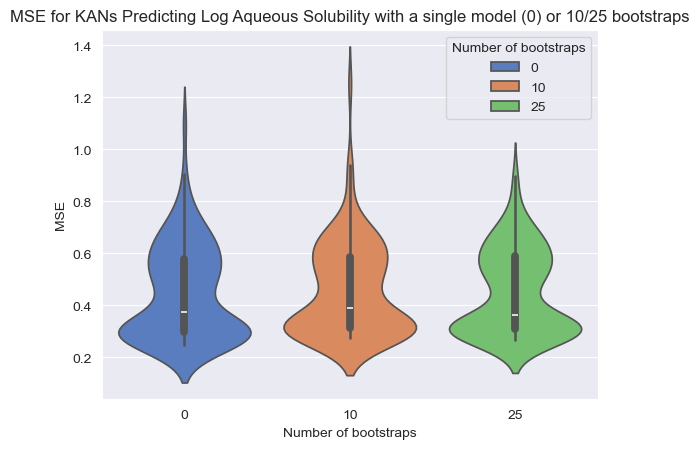

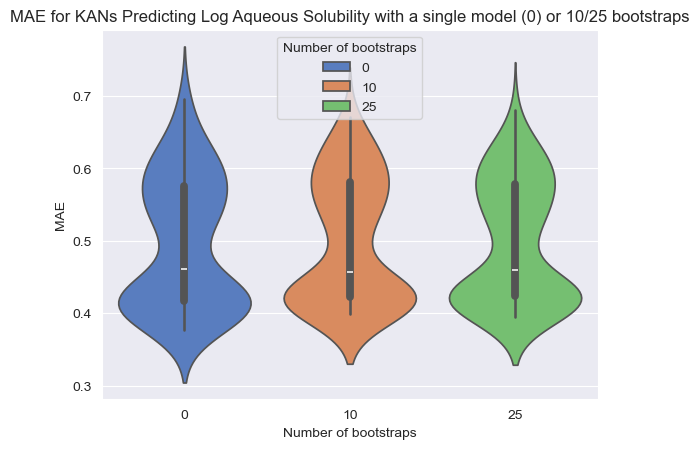

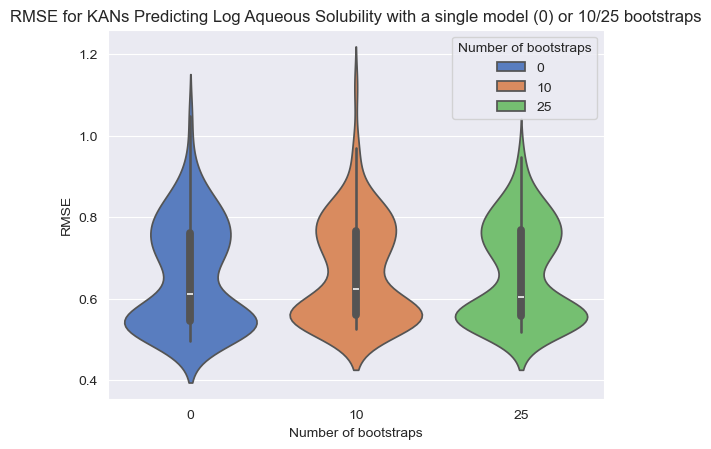

In [57]:
sns.set_style('darkgrid')
METRICS = ['R2', 'MSE', 'MAE', 'RMSE']

for metric in METRICS:
    sns.violinplot(data=df_all, x='num_bootstraps', y=metric, hue='num_bootstraps', palette='muted')
    plt.title(f'{metric} for KANs Predicting Log Aqueous Solubility with a single model (0) or 10/25 bootstraps')
    plt.xlabel('Number of bootstraps')
    plt.ylabel(metric)
    plt.legend(title='Number of bootstraps')
    plt.show()